In [1]:
import pandas as pd
import os 
import random
import subprocess

import dask.dataframe as dd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
pwd -P

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza_last_gen'

In [3]:
kendall_corr = pd.read_csv('../kendall_tau_last_gen/kendall_corr_bio12.csv')

In [4]:
kendall_corr

,K_tau,K_tau_p,MAF
0,-0.128233,3.793000e-04,0.288067
1,-0.068903,5.618413e-02,0.077929
2,0.029007,4.214665e-01,0.092449
3,-0.215472,2.387434e-09,0.078113
4,-0.215472,2.387434e-09,0.078113
...,...,...,...
1048630,0.164021,5.477516e-06,0.169091
1048631,-0.100638,5.298454e-03,0.069410
1048632,-0.100638,5.298454e-03,0.069410
1048633,0.062921,8.117636e-02,0.466354


In [5]:
path = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza_last_gen/'

In [10]:
## create a dir 


# create sbatch files to submit on cedar server
shfiles = []

seed = random.randint(1,100000000)
file = 'wza.sh'
cmd = f'python general_WZA_script_mod_polynomial_order7.py --correlations ../kendall_tau_last_gen/kendall_corr_bio12.csv --summary_stat K_tau_p --window "block" --output wza_kendalltau_results_bio12_poly7.csv --sep ","'
text = f'''#!/bin/bash
#SBATCH --job-name=wza_kendall
#SBATCH --time=1:00:00  # Time limit set to 4 days
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=30gb
#SBATCH --output=wza_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

module load python/3.11_conda
conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake
export LD_LIBRARY_PATH="/home/tbellagio/miniforge3/envs/run_baypass/lib:$LD_LIBRARY_PATH"
cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza_last_gen
{cmd}


'''
with open(file, 'w') as o:
    o.write("%s" % text)
shfiles.append(file)

In [11]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 57172


In [12]:
wza = pd.read_csv('wza_kendalltau_results_bio12_poly7.csv').reset_index()

In [13]:
wza[wza['Z_pVal'].isna()]

,index,gene,SNPs,hits,Z,top_candidate_p,Z_pVal


In [14]:
wza.dropna()

,index,gene,SNPs,hits,Z,top_candidate_p,Z_pVal
0,0,1_0,206,2,9.144696,0.611389,0.056326
1,1,1_1,3,0,1.886596,1.000000,0.054496
2,2,1_10,22,0,1.849873,1.000000,0.203222
3,3,1_100,51,0,1.835144,1.000000,0.290293
4,4,1_1000,9,0,0.943231,1.000000,0.249336
...,...,...,...,...,...,...,...
16624,16624,5_995,36,0,-0.098735,1.000000,0.480224
16625,16625,5_996,3,1,2.995015,0.029701,0.007245
16626,16626,5_997,27,0,3.467534,1.000000,0.091017
16627,16627,5_998,6,0,-1.541270,1.000000,0.807317


In [ ]:
gene - the name of the window
SNPs - the number of SNPs in this window
hits - the number of SNPs in the 99th percentile (not used for anything, just good to know)
Z - the Z score calculated for the gene
top_candidate_p - the result of the top-candidate method of Yeaman et al (2016 - Science)
LA - an indicator of whether the gene is causal for local adaptation
position - the average position of all SNPs in the window
Z_pVal - the p-value of the Z score (This is the WZA score)


In [9]:
wza['top_candidate_p'].value_counts()

top_candidate_p
1.000000    15200
0.029701       26
0.039404       24
0.067935       22
0.019900       20
            ...  
1.000000        1
0.998923        1
0.615104        1
0.999504        1
0.999883        1
Name: count, Length: 973, dtype: int64

NameError: name 'biovar' is not defined

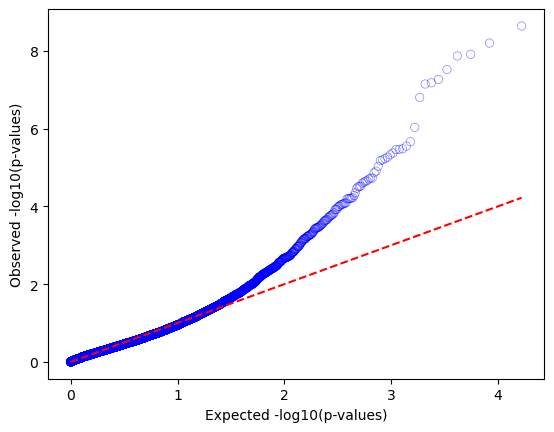

In [10]:
observed_quantiles = -np.log10(np.sort(wza['Z_pVal'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(wza), 1, len(wza)))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot for {biovar}) WZA')

plt.show()

In [15]:
wza['chrom'] = wza['gene'].str.split('_').str[0].astype(int)
wza['pos'] = wza['gene'].str.split('_').str[1].astype(int)

In [16]:
min = wza.loc[wza['Z_pVal']!=0]['Z_pVal'].min()

In [17]:
wza.loc[wza['Z_pVal']==0]

,index,gene,SNPs,hits,Z,top_candidate_p,Z_pVal,chrom,pos


In [18]:
#wza.loc[wza['Z_pVal']==0, 'Z_pVal'] = min

In [19]:
wza.sort_values('Z_pVal')

,index,gene,SNPs,hits,Z,top_candidate_p,Z_pVal,chrom,pos
2038,2038,1_2865,6,6,8.220598,1.000000e-12,1.432491e-08,1,2865
11789,11789,4_2115,11,9,8.626430,5.401450e-17,8.438593e-07,4,2115
13595,13595,5_1017,4,4,6.350377,1.000000e-08,1.044766e-06,5,1017
128,128,1_1113,8,4,7.455634,6.778784e-07,1.735504e-06,1,1113
12808,12808,4_3051,74,65,20.891295,1.011050e-119,2.451474e-06,4,3051
...,...,...,...,...,...,...,...,...,...
15594,15594,5_2852,8,0,-5.857334,1.000000e+00,9.996731e-01,5,2852
3095,3095,1_3825,9,0,-6.321830,1.000000e+00,9.998066e-01,1,3825
13660,13660,5_1076,6,0,-5.706361,1.000000e+00,9.998447e-01,5,1076
8533,8533,3_2198,6,0,-5.861254,1.000000e+00,9.998956e-01,3,2198


/tmp/ipykernel_2992915/1017192587.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


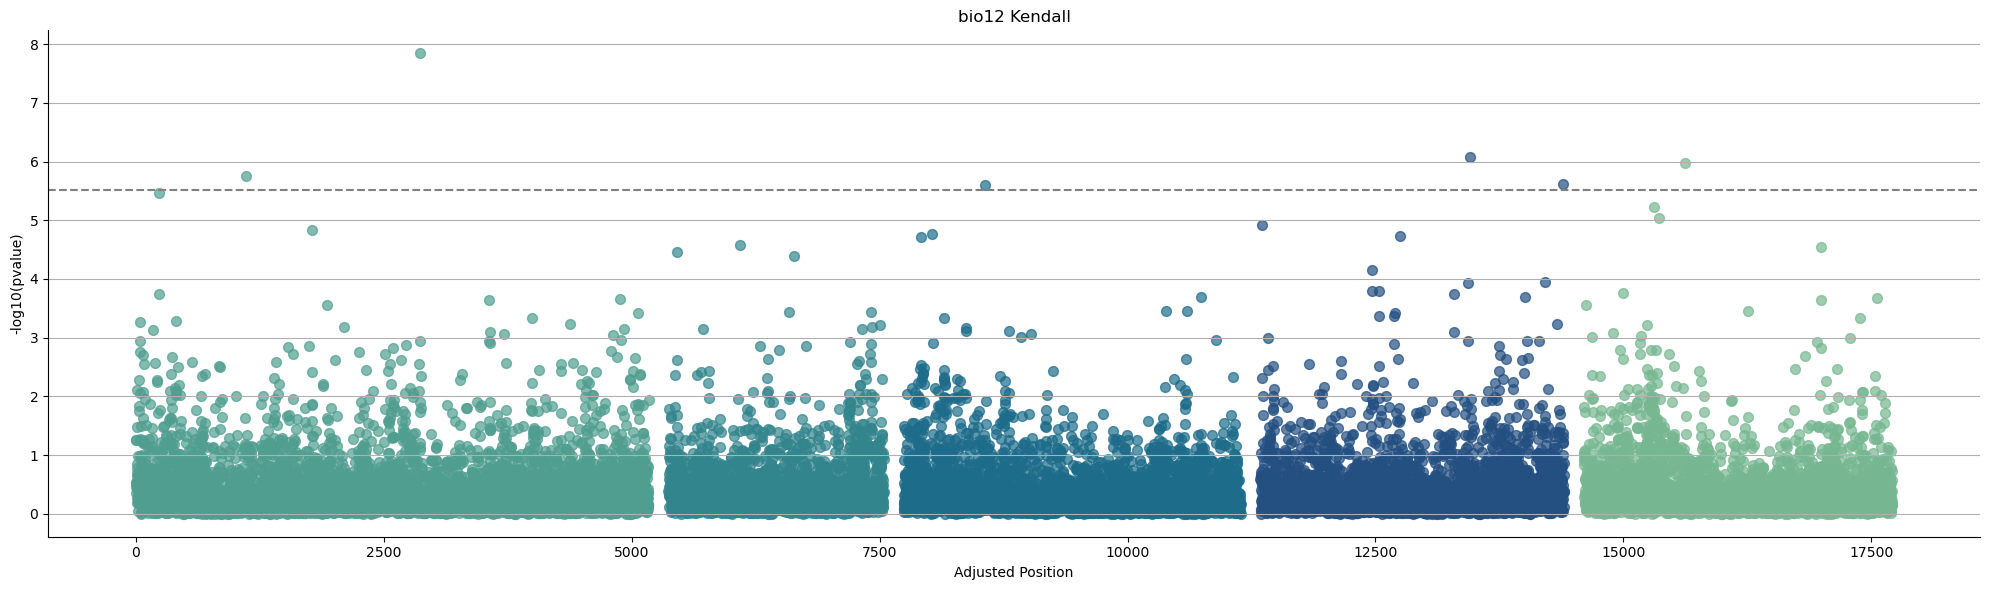

In [21]:
threshold_value = 0.05 / len(wza)
biovar='bio12'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['Z_pVal','pos','chrom']].copy()


# Parsing chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

colors = sns.color_palette("crest", n_colors = 5)

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Buffer to prevent overlap

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Normalize sizes for better visualization
size_transform = 2  # Adjust this factor as needed


# Create a color map based on `n_est`
#df['color'] = df['n_est'].map(lambda x: cmap(norm(x)))

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7,  # Transparency for better visibility
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
            s= 50)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Kendall')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.grid(axis='y')



# Create a legend for the number of estimated lineages
#handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(n)), markersize=10, label=f'Lineages {n}') for n in sorted(n_est_unique)]
#plt.legend(handles=handles, title="Estimated Lineages", bbox_to_anchor=(1.05, 1), loc='upper left')

# Threshold line
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Show the plot
plt.tight_layout()

plt.savefig(f'manhattan_{biovar}_kendall.pdf')
plt.savefig(f'manhattan_{biovar}_kendall.png',dpi=600)
plt.show()


In [ ]:
#genes = ['2_199', '3_2730', '5_2244']
genes = ['2_1265', '4_801']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}'
        )

/tmp/ipykernel_3175312/1489910986.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


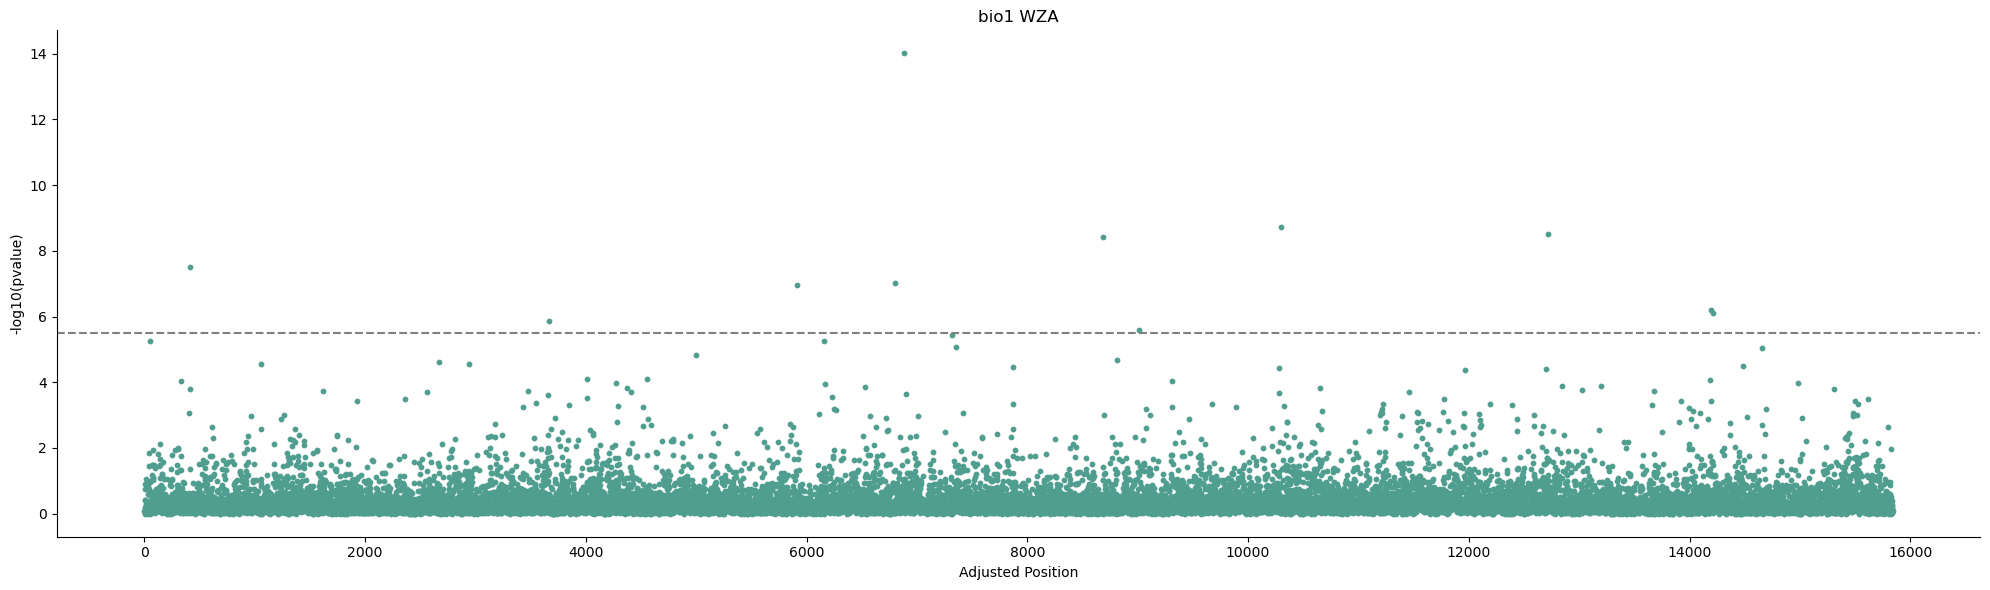

In [54]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['Z_pVal', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
#plt.savefig(f'manhattan_{biovar}.png')
plt.show()

/tmp/ipykernel_3175312/2368688080.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


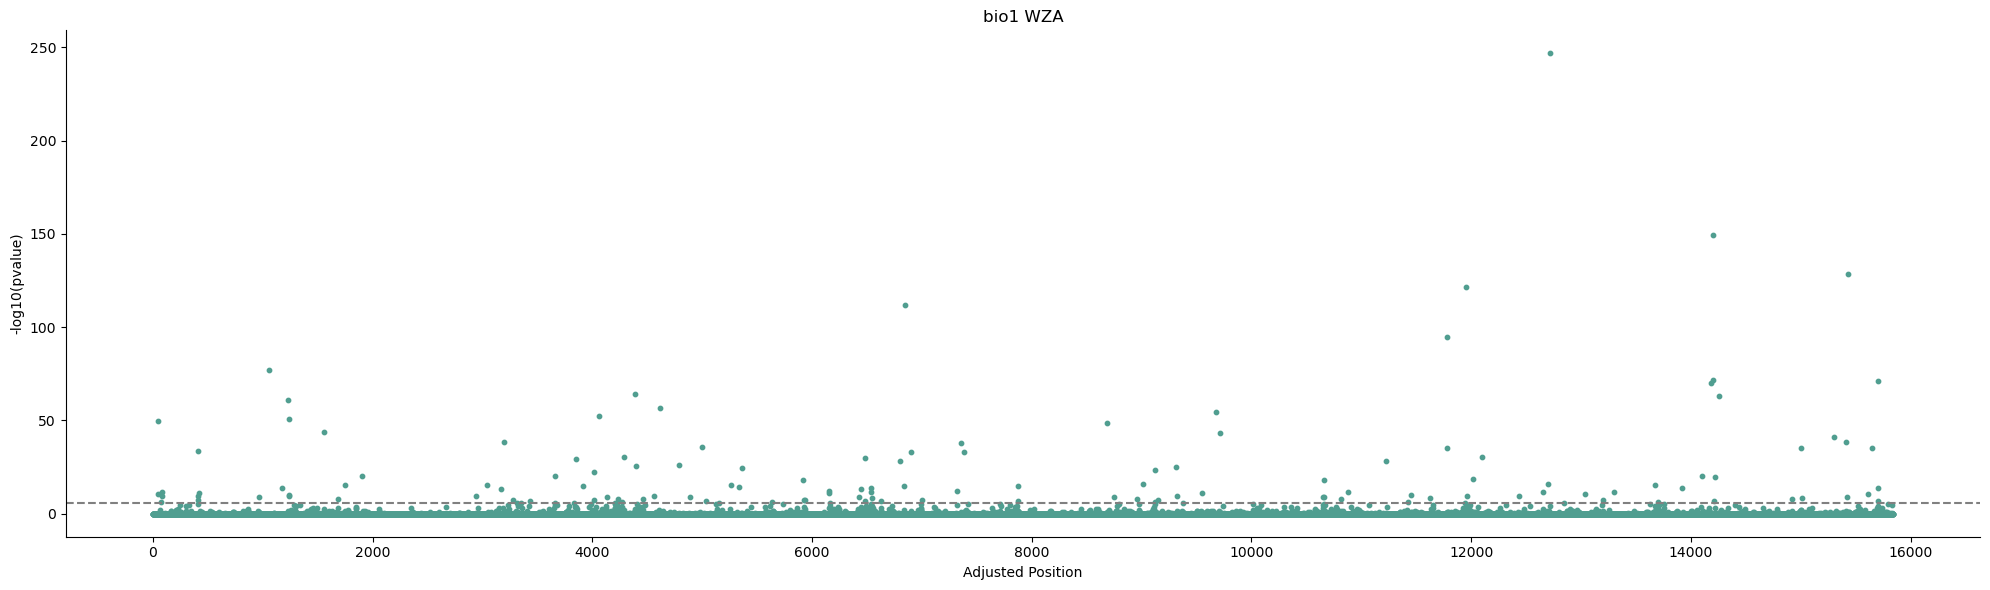

In [50]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['top_candidate_p', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['top_candidate_p'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
plt.savefig(f'manhattan_{biovar}.png')
plt.show()